In [2]:
'''This code uses AI assistance for syntax, formatting, and adding some comments'''


'This code uses AI assistance for syntax, formatting, and adding some comments'

In [3]:
# Define constants
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d  # interpolation function
import scipy.constants as const

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # ignore all UserWarning messages

# Physical constants
G_F = 1.1663787e-23  # Fermi constant (eV^-2)
hbar = const.hbar  # Reduced Planck constant
c = const.c  # Speed of light
eV = const.electron_volt  # Electron volt
MeV = eV * 1e6  # Mega-electron volt
cm = 0.01  # centimeter
R_sun = 6.957e8  # Solar radius (m)
# Hypothetical Avogadro constant
N_A = 6.022e23 

# 2-flavor oscillation parameters
theta_v = np.radians(33)  # vacuum mixing angle
delta_m2 = 7.5e-5  # eV^2


In [5]:
import math

# Load electron density file
filename = "/Users/hcjhuang/Documents/各種資料/neutrino_simulator/BP2000 electron density.txt"

def custom_density_function(r):
    """
    Custom electron density function
    
    Parameters:
    r: radius from the solar center (in units of solar radius)
    
    Returns:
    electron density value
    """
    return 10 ** (28.0 - 4.3*r)

def solar_electron_density(filename=None, model="BP2000", debug=False):
    """
    Compute solar electron density
    
    Parameters:
    filename: data file name (required for BP2000 model)
    model: model to use ("BP2000" or "custom")
    debug: whether to print debug information
    
    Returns:
    tuple: (r_vals, Ne_vals, success)
    """
    r_vals = []  # list to store radius values
    Ne_vals = []  # list to store electron densities
    
    if model == "custom":
        if debug:
            print("Using custom electron density model")
        
        num_points = 1000  # number of points
        r_min = 0.0       # solar center
        r_max = 1.00135   # solar surface
        
        for i in range(num_points):
            r = r_min + i * (r_max - r_min) / (num_points - 1)
            r_vals.append(r)
            Ne_vals.append(custom_density_function(r))
        
        if debug:
            print(f"Number of r_vals points: {len(r_vals)}")
            print("Ne_vals: ", end="")
            for i in range(min(5, len(Ne_vals))):
                print(f"{Ne_vals[i]:.2e} ", end="")
            print("...")
        
        return r_vals, Ne_vals, True
    
    elif model == "BP2000":
        N_A = 6.02214076e23
        
        if filename is None:
            if debug:
                print("Error: filename is required for BP2000 model")
            return r_vals, Ne_vals, False
            
        try:
            with open(filename, 'r') as file:
                lines = file.readlines()
                
                if len(lines) < 2:
                    return r_vals, Ne_vals, False
                
                for line in lines[2:]:
                    line = line.strip()
                    if not line or "BP2000" in line:
                        continue
                    
                    try:
                        parts = line.split()
                        if len(parts) >= 2:
                            r = float(parts[0])
                            log_Ne_NA = float(parts[1])
                            r_vals.append(r)
                            Ne_vals.append((10 ** log_Ne_NA) * N_A)
                    except (ValueError, IndexError):
                        continue
                
                if debug:
                    print("Using BP2000 electron density model")
                    print(f"Number of r_vals points: {len(r_vals)}")
                    print("Ne_vals: ", end="")
                    for i in range(min(5, len(Ne_vals))):
                        print(f"{Ne_vals[i]} ", end="")
                    print("...")
                
                return r_vals, Ne_vals, len(r_vals) > 0
                
        except FileNotFoundError:
            print(f"Error: Could not open file {filename}")
            return r_vals, Ne_vals, False
        except Exception as e:
            print(f"Error reading file: {e}")
            return r_vals, Ne_vals, False
    
    else:
        if debug:
            print(f"Error: Unknown model '{model}'. Available models: 'BP2000', 'custom'")
        return r_vals, Ne_vals, False

# Example usage
if __name__ == "__main__":
    r_vals, Ne_vals, success = solar_electron_density(filename, model="BP2000", debug=False)
    if success:
        print(f"Successfully generated {len(r_vals)} data points with model")


Successfully generated 2499 data points with model


In [7]:
# Compute conversion factors needed for Schrödinger equation
G_F = 1.1663787e-23
hbar = const.hbar
c = const.c
eV = const.electron_volt
MeV = eV * 1e6
cm = 0.01
R_sun = 6.957e8
N_A = 6.022e23
fm = 1e-15

hbarc = hbar*c  # ℏ * c in J·m
print(f"ℏ * c = {hbarc:.5e} J·m")
hbarceV = hbarc / (eV * fm)  # ℏ * c in eV·fm
print(f"ℏ * c = {hbarceV:.5f} eV·fm")
factor = fm**(-1) / hbarceV  # 1 fm^-1 = ? eV
print(f"1 eV = {factor:.5e} m^-1")
factor_cm = factor*0.01
print(f"1 eV = {factor_cm:.5e} cm^-1")
factor_cm1 = 1/factor_cm
print(f"1 cm^-1 = {factor_cm1:.5e} eV")

ℏ * c = 3.16153e-26 J·m
ℏ * c = 197326980.45930 eV·fm
1 eV = 5.06773e+06 m^-1
1 eV = 5.06773e+04 cm^-1
1 cm^-1 = 1.97327e-05 eV


In [17]:
"""
Unit Conversion Notes

ℏ * c = 3.16153e-26 J·m
ℏ * c = 197.327 MeV·fm
1= 197.327 MeV·fm ⇒  1/𝑓𝑚 =197.327 MeV
1/𝑓𝑚 =197.327 MeV 
⇒ 1 eV=1/(197.327x10^6 𝑓𝑚) 
⇒  10^15/(197.327x10^6 ) 𝑚^(−1)= 5.06773e+06 𝑚^(−1)

"""

'\nUnit Conversion Notes\n\nℏ * c = 3.16153e-26 J·m\nℏ * c = 197.327 MeV·fm\n1= 197.327 MeV·fm ⇒  1/𝑓𝑚 =197.327 MeV\n1/𝑓𝑚 =197.327 MeV \n⇒ 1 eV=1/(197.327x10^6 𝑓𝑚) \n⇒  10^15/(197.327x10^6 ) 𝑚^(−1)= 5.06773e+06 𝑚^(−1)\n\n'

In [9]:
# Compute electron potential
DEBUG_MODE = False

def electron_potential(r, r_vals, Ne_vals):
    """
    Compute electron potential using linear interpolation and simple extrapolation
    
    Parameters:
    r: radius
    r_vals: array of radii
    Ne_vals: array of electron densities
    
    Returns:
    Electron potential in eV
    """
    
    if r < r_vals[0]:
        # Extrapolate: assume density before solar center equals central density
        V = math.sqrt(2) * G_F * Ne_vals[0] * factor_cm1**3
        if DEBUG_MODE:
            print(f"[DEBUG] r = {r:.2f} < min(r_vals), using central density: V = {V:.3e}")
        return V 
    
    elif r > r_vals[-1]:
        # Outside Sun, density = 0
        if DEBUG_MODE:
            print(f"[DEBUG] r = {r:.2f} > max(r_vals), assumed density = 0: V = 0")
        return 0
    
    else:
        idx = 0
        for i in range(len(r_vals)):
            if r_vals[i] <= r:
                idx = i
            else:   
                break
        
        if idx >= len(r_vals) - 1:
            idx = len(r_vals) - 2
        
        r1 = r_vals[idx]
        r2 = r_vals[idx + 1]
        Ne1 = Ne_vals[idx]
        Ne2 = Ne_vals[idx + 1]
        
        Ne_interp = Ne1 + (r - r1) * (Ne2 - Ne1) / (r2 - r1)
        V = math.sqrt(2) * G_F * Ne_interp * factor_cm1**3

        if DEBUG_MODE:
            print(f"[DEBUG] r = {r:.2f}, interpolated Ne = {Ne_interp:.3e}, V = {V:.3e}")
            
        return V

# Usage example
if __name__ == "__main__":
    r_vals, Ne_vals, success = solar_electron_density(filename)
    
    if success and DEBUG_MODE:
        print("BP2000 model loaded successfully!")
        print(f"Data points: {len(r_vals)}")
        test_radii = [0.0, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 2.0]
        print("\n=== Electron potential test ===")
        for r in test_radii:
            potential = electron_potential(r, r_vals, Ne_vals)
            print(f"r = {r:.1f} R_sun: V_e = {potential:.6e} eV")

In [19]:
""" Example of Linear Interpolation:

To interpolate r, you must know which interval it falls into:
Assume r = 1500
And r_vals = [0, 1000, 2000, 3000] (idx: 0,1,2,3)
Then you want to find:
idx = 1 (because r_vals[1] = 1000, which is the maximum value ≤ 1500)
if idx >= len(r_vals) - 1: idx = len(r_vals) – 2 r_vals = [0, 1000, 2000, 3000] # len = 4, maximum index = 3
If r = 4000, idx = 3 # because r_vals[3] = 3000 <= 4000
Without correction, it will become:
r1 = r_vals[3]
r2 = r_vals[4] # IndexError!
if idx >= len(r_vals) - 1: (4 >= 4-1 = 3 (the last one is 3))
idx = len(r_vals) - 2 # Make idx + 1 safe (idx=4-2) Next, r1 and r2 will be modified to (anyway, the last two)
r1 = r_vals[2]
r2 = r_vals[3] """

' Example of Linear Interpolation:\n\nTo interpolate r, you must know which interval it falls into:\nAssume r = 1500\nAnd r_vals = [0, 1000, 2000, 3000] (idx: 0,1,2,3)\nThen you want to find:\nidx = 1 (because r_vals[1] = 1000, which is the maximum value ≤ 1500)\nif idx >= len(r_vals) - 1: idx = len(r_vals) – 2 r_vals = [0, 1000, 2000, 3000] # len = 4, maximum index = 3\nIf r = 4000, idx = 3 # because r_vals[3] = 3000 <= 4000\nWithout correction, it will become:\nr1 = r_vals[3]\nr2 = r_vals[4] # IndexError!\nif idx >= len(r_vals) - 1: (4 >= 4-1 = 3 (the last one is 3))\nidx = len(r_vals) - 2 # Make idx + 1 safe (idx=4-2) Next, r1 and r2 will be modified to (anyway, the last two)\nr1 = r_vals[2]\nr2 = r_vals[3] '

In [11]:
# Calculate Hamiltonian (print all vac, mat, tot matrices)
DEBUG_MODE = False  # Set True to print detailed info, False to suppress

def get_pmns_matrix_2flavor():
    """
    Get the 2-flavor PMNS matrix
    """
    cos_theta = math.cos(theta_v)
    sin_theta = math.sin(theta_v)
    
    return [
        [cos_theta, sin_theta],
        [-sin_theta, cos_theta]
    ]

def hamiltonian_2flavor(r, E_nu, r_vals, Ne_vals):
    """
    Calculate the 2-flavor neutrino Hamiltonian
    
    Parameters:
    r: radial distance
    E_nu: neutrino energy
    r_vals: array of radial distances
    Ne_vals: array of electron densities
    
    Returns:
    2x2 Hamiltonian matrix
    """
    
    # Vacuum term (2x2 matrix)
    H_vac = [
        [0.0, 0.0],
        [0.0, delta_m2/(2.0 * E_nu)]
    ]
    
    # Print H_vac
    if DEBUG_MODE:  # f"..." is Python f-string; embeds variable values
        print(f"H_vac (mass eigenstate basis) at r = {r:.1f} R_sun:")
        print(f"  [[{H_vac[0][0]:.6e}, {H_vac[0][1]:.6e}],")
        print(f"   [{H_vac[1][0]:.6e}, {H_vac[1][1]:.6e}]] eV")
    
    # PMNS matrix (2x2)
    U = get_pmns_matrix_2flavor()
    
    # Transform to flavor basis (U * H_vac * U^†)
    # First compute H_vac * U^†
    H_vac_Uconj = [[0.0, 0.0], [0.0, 0.0]]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                H_vac_Uconj[i][j] += H_vac[i][k] * U[j][k]  # U^† = U^T for real matrix
    
    # Compute U * (H_vac * U^†)
    H_vac_flavor = [[0.0, 0.0], [0.0, 0.0]]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                H_vac_flavor[i][j] += U[i][k] * H_vac_Uconj[k][j]
                
    # Print H_vac in flavor basis
    if DEBUG_MODE:
        print(f"H_vac (flavor basis) at r = {r:.1f} R_sun:")
        print(f"  [[{H_vac_flavor[0][0]:.6e}, {H_vac_flavor[0][1]:.6e}],")
        print(f"   [{H_vac_flavor[1][0]:.6e}, {H_vac_flavor[1][1]:.6e}]] eV")

    
    # Electron potential
    V_e = electron_potential(r, r_vals, Ne_vals)  # order matters: r, r_vals, Ne_vals
    
    # Matter effect term (only electron neutrino contributes)
    H_matter = [
        [V_e, 0.0],
        [0.0, 0.0]
    ]
    
    # Print matter term
    if DEBUG_MODE:
        print(f"H_matter at r = {r:.1f} R_sun:")
        print(f"  [[{H_matter[0][0]:.6e}, {H_matter[0][1]:.6e}],")
        print(f"   [{H_matter[1][0]:.6e}, {H_matter[1][1]:.6e}]] eV")
    
    # Total Hamiltonian
    H_total = [[0.0, 0.0], [0.0, 0.0]]
    for i in range(2):
        for j in range(2):
            H_total[i][j] = H_vac_flavor[i][j] + H_matter[i][j]
    
    if DEBUG_MODE:
        print(f"H_total at r = {r:.1f} R_sun:")
        print(f"  [[{H_total[0][0]:.6e}, {H_total[0][1]:.6e}],")
        print(f"   [{H_total[1][0]:.6e}, {H_total[1][1]:.6e}]] eV")
        print("-" * 50)
    
    return np.array(H_total)  # Ensure return is a NumPy array

# Example usage of Hamiltonian
if __name__ == "__main__":
    # Use custom model
    # r_vals, Ne_vals, success = solar_electron_density(model="custom", debug=False)
    # Use BP2000 model
    r_vals, Ne_vals, success = solar_electron_density(filename)
    
    if success:
        print("BP2000 model loaded successfully!")
        print(f"Data points: {len(r_vals)}")
        test_radii = [0.0, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 2.0]
        
        if DEBUG_MODE:
            # Test electron potential
            print("\n=== Electron potential test ===")
        
            for r in test_radii:  # Print potential for specified r
                potential = electron_potential(r, r_vals, Ne_vals)
                print(f"r = {r:.1f} R_sun: V_e = {potential:.6e} eV")
        
        # Test Hamiltonian calculation
        if DEBUG_MODE:
            print("\n=== Hamiltonian test ===")
            E_nu = 10e6  # neutrino energy 10 MeV
            print(f"Neutrino energy: {E_nu} eV")
        
            for r in test_radii:
                H = hamiltonian_2flavor(r, E_nu, r_vals, Ne_vals)
               
    else:
        print("Failed to load BP2000 model!")


BP2000 model loaded successfully!
Data points: 2499


In [13]:
# Conversion factors for Schrödinger equation
G_F = 1.1663787e-23  # Fermi constant (eV^-2)
hbar = const.hbar  # reduced Planck constant
c = const.c  # speed of light
eV = const.electron_volt  # electron volt
MeV = eV * 1e6  # mega electron volt
cm = 0.01  # centimeter
R_sun = 6.957e8  # solar radius (m)
N_A = 6.022e23  # Avogadro constant (adjust as needed)
fm = 1e-15  # femtometer

# ℏ * c in J·m
hbarc = hbar * c
print(f"ℏ * c = {hbarc:.5e} J·m")
# ℏ * c in eV·fm
hbarceV = hbarc / (eV * fm)
print(f"ℏ * c = {hbarceV:.5f} eV·fm")
# Conversion factor: 1 fm⁻¹ = ? eV
factor = fm**(-1) / hbarceV
print(f"1 eV = {factor:.5e} m⁻¹")

ℏ * c = 3.16153e-26 J·m
ℏ * c = 197326980.45930 eV·fm
1 eV = 5.06773e+06 m⁻¹


In [27]:
"""
Schrödinger equation unit conversion explanation
Factor: 1 eV = 5.06773e+06 m^(-1)

Because the Hamiltonian implicitly uses solar distance units 
(the electron density file has distances in units of solar radius), 
the RHS of the Schrödinger equation needs to be multiplied by:

dψ/dx (1/m) = -i * H * ψ (1/(sun distance)) * sun distance

This ensures that the resulting probability is correct in physical units, 
because actual probability is measured in meters (not in units of solar radius).

Next, to make the units consistent on both sides, multiply the RHS by the "factor":
⇒ dψ/dx (1/m) = -i * H(eV) * ψ * factor (1 eV = 5.06773e+06 m^(-1))

This is the origin of the conversion_factor.
"""

'\nSchrödinger equation unit conversion explanation\nFactor: 1 eV = 5.06773e+06 m^(-1)\n\nBecause the Hamiltonian implicitly uses solar distance units \n(the electron density file has distances in units of solar radius), \nthe RHS of the Schrödinger equation needs to be multiplied by:\n\ndψ/dx (1/m) = -i * H * ψ (1/(sun distance)) * sun distance\n\nThis ensures that the resulting probability is correct in physical units, \nbecause actual probability is measured in meters (not in units of solar radius).\n\nNext, to make the units consistent on both sides, multiply the RHS by the "factor":\n⇒ dψ/dx (1/m) = -i * H(eV) * ψ * factor (1 eV = 5.06773e+06 m^(-1))\n\nThis is the origin of the conversion_factor.\n'

In [15]:
# Define Schrödinger equation
DEBUG_MODE = False  # Set False to silence all intermediate outputs

def schrodinger_rhs(r, psi_flat, E_nu, r_vals, Ne_vals):
    # psi_flat is a real array containing [Re(psi_e), Im(psi_e), Re(psi_mu), Im(psi_mu)]
    # Reconstruct complex vector from flattened array
    psi = np.array([psi_flat[0] + 1j * psi_flat[1],
                    psi_flat[2] + 1j * psi_flat[3]])  # ψ(r)
    
    # Get Hamiltonian H(r) in units of eV
    H = np.array(hamiltonian_2flavor(r, E_nu, r_vals, Ne_vals))  # 2x2 matrix
    
    # Unit conversion: H is [eV], r is [R_sun], 
    # to make dψ/dr consistent, multiply by conversion factor
    # 1 eV ≈ 5.07e6 m⁻¹, thus 1 eV ≈ 5.07e6 / R_sun
    # Units: [eV * m / m = dimensionless in terms of dx⁻¹], i.e., 1/R_sun × ψ
    conversion_factor = R_sun * factor  

    dpsi_dx = -1j * H * conversion_factor @ psi  # @ is matrix multiplication

    # Flatten complex derivatives for real ODE solver
    dpsi_dx_flat = np.array([dpsi_dx[0].real, dpsi_dx[0].imag,
                             dpsi_dx[1].real, dpsi_dx[1].imag])

    norm = np.sum(np.abs(psi)**2)

    # Print all key intermediate variables and units
    if DEBUG_MODE:
        print(f"r = {r:.4f} R_sun")
        print("ψ(r):")
        print(psi)
        print("H(r): [eV]")
        print(H)
        print(f"Conversion factor = {conversion_factor:.3e} (eV → R_sun⁻¹)")
        print("dψ/dr = -i * H_scaled @ ψ: [R_sun⁻¹]")
        print(dpsi_dx)
        print(f"||ψ||² = {norm:.6f}")
        print("-" * 50)

    return dpsi_dx_flat

# Main execution: test Schrödinger RHS
if __name__ == "__main__":
    # Use BP2000 model
    r_vals, Ne_vals, success = solar_electron_density(filename)

    if success:
        E_nu = 10e6  # 10 MeV neutrino
        r_tests = [0.0, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 2.0]
        psi_test = [1.0, 0.0, 0.0, 0.0]
        
        for r in r_tests:
            if DEBUG_MODE:
                print(f"\n=== Test r = {r:.2f} R_sun ===")
            _ = schrodinger_rhs(r, psi_test, E_nu, r_vals, Ne_vals)  # Execute without using result
    
    else:
        print("Failed to load BP2000 model!")

In [17]:
# Wavefunction evolution and probability calculation
# Simplified wavefunction evolution module
import numpy as np
from scipy.integrate import solve_ivp

# Solve Schrödinger equation
def solve_neutrino_evolution(E_nu, r_eval, r_vals, Ne_vals, r_max):
    psi0_complex = np.array([1.0, 0.0], dtype=complex)  # Only electron neutrino, no muon neutrino
                                                          # Represents ψ_e = 1 + 0i, ψ_μ = 0 + 0i

    # Flatten complex initial wavefunction into real array: [Re(psi_e), Im(psi_e), Re(psi_mu), Im(psi_mu)]
    psi0_flat = np.array([psi0_complex[0].real, psi0_complex[0].imag,
                          psi0_complex[1].real, psi0_complex[1].imag])
    
    sol = solve_ivp(
        fun=lambda r, y: schrodinger_rhs(r, y, E_nu, r_vals, Ne_vals),
        t_span=(0.0, r_max),  # Integration range from 0 to r_max
        y0=psi0_flat,          # Initial condition (real array)
        t_eval=r_eval,         # Evaluate solution at specific r points
        method='Radau',        # Implicit Runge-Kutta (stiff solver)
        rtol=1e-8,
        atol=1e-11
    )

    # Check if solution succeeded
    if not sol.success:
        print(f"Numerical solver failed: {sol.message}")
        return None, None

    # Reconstruct complex wavefunction from flattened real array
    psi_e_real = sol.y[0, :]    # Real part of electron neutrino as a function of r
    psi_e_imag = sol.y[1, :]    # Imaginary part of electron neutrino as a function of r
    psi_mu_real = sol.y[2, :]   # Real part of muon neutrino as a function of r
    psi_mu_imag = sol.y[3, :]   # Imaginary part of muon neutrino as a function of r

    psi_vals = np.column_stack([psi_e_real + 1j * psi_e_imag,
                                psi_mu_real + 1j * psi_mu_imag])
    
    return r_eval, psi_vals

# Main program: only execute wavefunction evolution
if __name__ == "__main__":
    r_vals, Ne_vals, success = solar_electron_density(filename)

    if success:
        print("BP2000 model loaded successfully!")
        E_nu = 10e6  # 10 MeV neutrino

        print("\n=== Wavefunction evolution ===")
        r_eval = np.linspace(0.0, 2.0, 7)  # Sample points from 0 to 2 R_sun
        r_vals_out, psi_vals = solve_neutrino_evolution(E_nu, r_eval, r_vals, Ne_vals, r_max=2.0)

        # Print wavefunction and check normalization
        for i, r in enumerate(r_vals_out):
            psi = psi_vals[i]
            prob_sum = np.abs(psi[0])**2 + np.abs(psi[1])**2
            print(f"r = {r:.2f} R_sun: ψ = [{psi[0].real:.4f} + {psi[0].imag:.4f}i, "
                  f"{psi[1].real:.4f} + {psi[1].imag:.4f}i],  ||ψ||² = {prob_sum:.6f}")
    
        if not np.isclose(prob_sum, 1.0, atol=1e-6):
            print(f"⚠️  [Warning] Wavefunction norm ≠ 1 (r = {r:.2f}): ||ψ||² = {prob_sum:.6f}")

    else:
        print("Failed to load BP2000 model!")

BP2000 model loaded successfully!

=== Wavefunction evolution ===
r = 0.00 R_sun: ψ = [1.0000 + 0.0000i, 0.0000 + 0.0000i],  ||ψ||² = 1.000000
r = 0.33 R_sun: ψ = [-0.6141 + -0.4815i, -0.5052 + -0.3685i],  ||ψ||² = 1.000000
r = 0.67 R_sun: ψ = [0.1295 + -0.5769i, -0.2405 + -0.7698i],  ||ψ||² = 1.000000
r = 1.00 R_sun: ψ = [0.5869 + 0.2283i, 0.7722 + -0.0841i],  ||ψ||² = 1.000000
r = 1.33 R_sun: ψ = [-0.3486 + -0.1348i, -0.6684 + -0.6431i],  ||ψ||² = 1.000000
r = 1.67 R_sun: ψ = [0.1941 + 0.7093i, 0.1674 + 0.6566i],  ||ψ||² = 1.000000
r = 2.00 R_sun: ψ = [0.2520 + -0.2925i, 0.2565 + -0.8861i],  ||ψ||² = 1.000000


In [21]:
def compute_probabilities(r_vals, psi_vals):
    """
    Compute the flavor probabilities from the wavefunction ψ.

    Parameters:
        psi_vals: 2D complex wavefunction vectors at each position (N x 2)
        
    Returns:
        prob_e: Probability of ν_e at each position
        prob_mu: Probability of ν_μ at each position
    """
    prob_e_list = []
    prob_mu_list = []

    if DEBUG_MODE:
        print("\n=== Neutrino probability evolution ===")

    for i, r in enumerate(r_vals):  
        # enumerate: get both the index (i) and value (r) from r_vals
        # allows tracking the position index and corresponding wavefunction
        psi = psi_vals[i]
        prob_e = abs(psi[0])**2  # Electron neutrino probability
        prob_mu = abs(psi[1])**2  # Muon neutrino probability

        prob_e_list.append(prob_e)
        prob_mu_list.append(prob_mu)
        
        if DEBUG_MODE:
            print(f"r = {r:.4f} R_sun: P(ν_e) = {prob_e:.6f}, P(ν_μ) = {prob_mu:.6f}")
    return prob_e_list, prob_mu_list


if __name__ == "__main__":
    # Use BP2000 model
    r_vals, Ne_vals, success = solar_electron_density(filename)

    if success:
        print("BP2000 model loaded successfully!")
        E_nu = 10e6  # 10 MeV neutrino

        print("\n=== Wavefunction evolution ===")
        r_eval = np.linspace(0.0, 1.0, 7)  # Sample points from 0 to 1 R_sun
        r_vals_out, psi_vals = solve_neutrino_evolution(E_nu, r_eval, r_vals, Ne_vals, r_max=2.0)

        # Print wavefunction if DEBUG_MODE is True
        if DEBUG_MODE:
            for i, r in enumerate(r_vals_out):
                psi = psi_vals[i]
                print(f"r = {r:.2f} R_sun: ψ = [{psi[0].real:.4f} + {psi[0].imag:.4f}i, "
                      f"{psi[1].real:.4f} + {psi[1].imag:.4f}i]")

        # Compute probabilities
        prob_e_list, prob_mu_list = compute_probabilities(r_vals_out, psi_vals)

        # If DEBUG_MODE is False, print summary results
        if not DEBUG_MODE:
            print("\n=== Neutrino probability summary ===")
            for r, pe, pmu in zip(r_vals_out, prob_e_list, prob_mu_list):
                print(f"r = {r:.2f} R_sun: P(ν_e) = {pe:.4f}, P(ν_μ) = {pmu:.4f}")

    else:
        print("Failed to load BP2000 model!")


BP2000 model loaded successfully!

=== Wavefunction evolution ===

=== Neutrino probability summary ===
r = 0.00 R_sun: P(ν_e) = 1.0000, P(ν_μ) = 0.0000
r = 0.17 R_sun: P(ν_e) = 0.5506, P(ν_μ) = 0.4494
r = 0.33 R_sun: P(ν_e) = 0.6090, P(ν_μ) = 0.3910
r = 0.50 R_sun: P(ν_e) = 0.4417, P(ν_μ) = 0.5583
r = 0.67 R_sun: P(ν_e) = 0.3496, P(ν_μ) = 0.6504
r = 0.83 R_sun: P(ν_e) = 0.1149, P(ν_μ) = 0.8851
r = 1.00 R_sun: P(ν_e) = 0.3966, P(ν_μ) = 0.6034


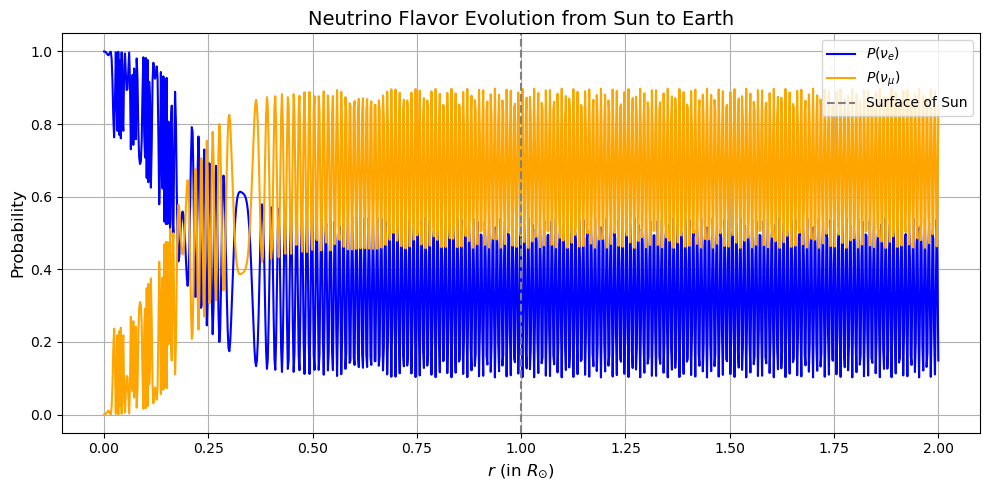

In [23]:
import matplotlib.pyplot as plt


# Plotting: P(ν_e) and P(ν_μ) vs r
def plot_probabilities(r_vals_out, prob_e_list, prob_mu_list):
    
    plt.figure(figsize=(10, 5))
    # Plot electron neutrino probability curve in blue and label it
    plt.plot(r_vals_out, prob_e_list, label=r'$P(\nu_e)$', color='blue')
    # Plot muon neutrino probability curve in orange and label it
    plt.plot(r_vals_out, prob_mu_list, label=r'$P(\nu_\mu)$', color='orange')

    # Dashed line for the Sun's surface
    plt.axvline(x=1.0, color='gray', linestyle='--', label='Surface of Sun')

    plt.xlabel(r'$r$ (in $R_{\odot}$)', fontsize=12)  # Set x-axis label, using LaTeX for solar radius
    plt.ylabel('Probability', fontsize=12)            # Set y-axis label as Probability
    plt.title('Neutrino Flavor Evolution from Sun to Earth', fontsize=14)  # Set plot title
    plt.legend()     # Show legend
    plt.grid(True)   # Enable grid for better readability
    plt.tight_layout()  # Adjust subplot parameters automatically to avoid clipping labels
    plt.show()


if __name__ == "__main__":
    TEST_MODE = False  # or True

    # Use custom electron density model
    # r_vals, Ne_vals, success = solar_electron_density(model="custom", debug=False)
    # Use BP2000 model
    r_vals, Ne_vals, success = solar_electron_density(filename)

    if success:
        E_nu = 10e6  # 10 MeV

        if TEST_MODE:
            r_eval = np.array([0.0, 0.1, 0.5, 1.0, 2.0])  # Test with fewer points
        else:
            r_eval = np.linspace(0.0, 2.0, 1000)         # Full simulation with many points

        r_vals_out, psi_vals = solve_neutrino_evolution(E_nu, r_eval, r_vals, Ne_vals, r_max=r_eval[-1])
        prob_e_list, prob_mu_list = compute_probabilities(r_vals_out, psi_vals)

        # Call plotting function
        plot_probabilities(r_vals_out, prob_e_list, prob_mu_list)

    else:
        print("Failed to load BP2000 model!")


In [37]:
"""
Parameter explanations:

r_vals: Distance points from the BP2000 electron density model
Ne_vals: Electron density values corresponding to r_vals
r: Current neutrino position
E_nu: Neutrino energy
r_eval: Distance points at which solve_ivp outputs the solution
r_max: Total integration distance
r_vals_out: Output distance points from solve_neutrino_evolution
psi_vals: Output wavefunctions from solve_neutrino_evolution
"""

'\nParameter explanations:\n\nr_vals: Distance points from the BP2000 electron density model\nNe_vals: Electron density values corresponding to r_vals\nr: Current neutrino position\nE_nu: Neutrino energy\nr_eval: Distance points at which solve_ivp outputs the solution\nr_max: Total integration distance\nr_vals_out: Output distance points from solve_neutrino_evolution\npsi_vals: Output wavefunctions from solve_neutrino_evolution\n'